## Pokemon: So You Want to Be a Master

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
from sklearn.feature_extraction import FeatureHasher

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve, auc

import time

### Reading in the Data

In [2]:
pokemon = pd.read_csv('pokemon.csv')
combats = pd.read_csv('combats.csv')
tests = pd.read_csv('tests.csv')

In [3]:
# The first one contains the Pokemon characteristics (the first column being the id of the Pokemon). 
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [4]:
# The second one contains information about previous combats. The first two columns contain the ids of the combatants and the third one the id of the winner. 
# Important: The Pokemon in the first columns attacks first.
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [5]:
tests.head()

,First_pokemon,Second_pokemon
0,129,117
1,660,211
2,706,115
3,195,618
4,27,656


### EDA

In [6]:
# No nulls
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        799 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


In [7]:
combats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   First_pokemon   50000 non-null  int64
 1   Second_pokemon  50000 non-null  int64
 2   Winner          50000 non-null  int64
dtypes: int64(3)
memory usage: 1.1 MB


In [8]:
tests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   First_pokemon   10000 non-null  int64
 1   Second_pokemon  10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


In [9]:
print('There are', len(pokemon), 'pokemon in our datatset.')

There are 800 pokemon in our datatset.


In [10]:
print('There are', len(combats), 'pokemon battles in our dataset.')

There are 50000 pokemon battles in our dataset.


### Let's explore the different types of Pokemon we have in our dataset.

#### Plotting out the Type 1 and Type 2 Frequency Distributions

Text(0, 0.5, 'Frequency')

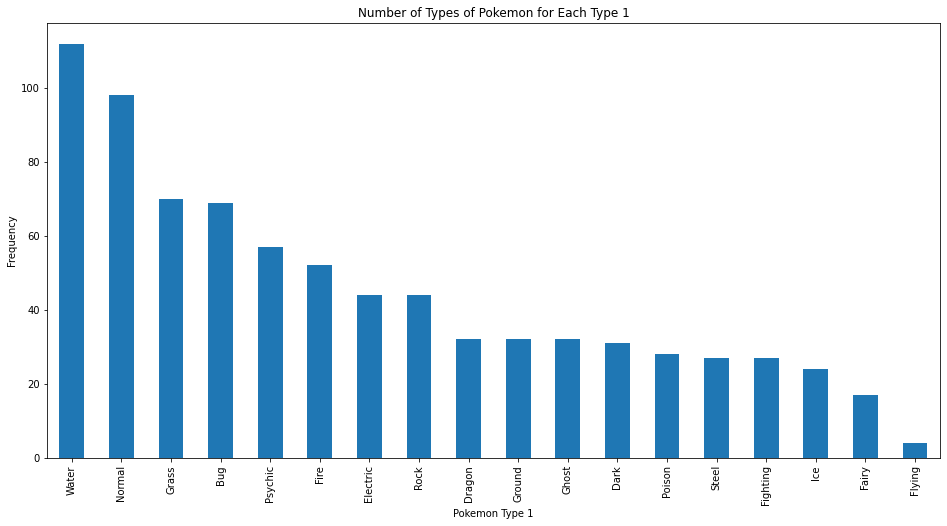

In [11]:
ax = pokemon['Type 1'].value_counts().plot(kind='bar',
                                    figsize=(16,8),
                                    title="Number of Types of Pokemon for Each Type 1")
ax.set_xlabel("Pokemon Type 1")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

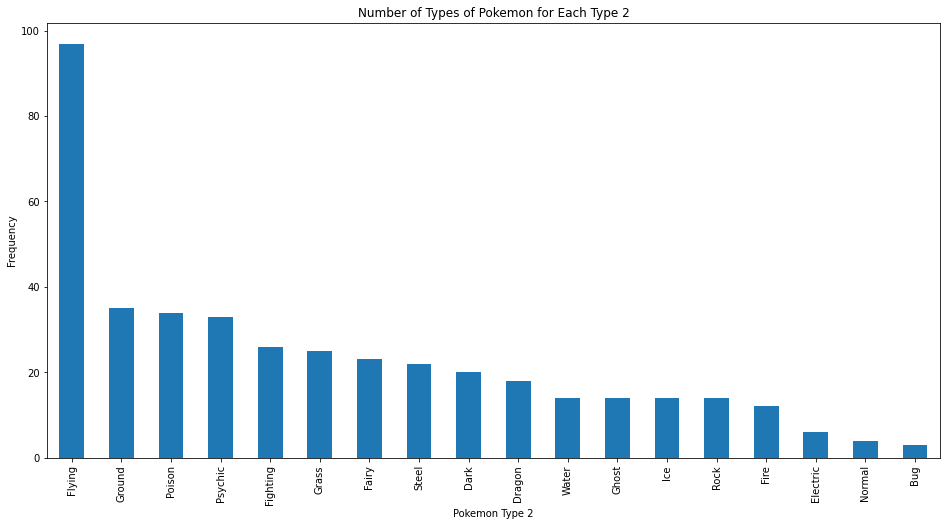

In [12]:
ax2 = pokemon['Type 2'].value_counts().plot(kind='bar',
                                    figsize=(16,8),
                                    title="Number of Types of Pokemon for Each Type 2")
ax2.set_xlabel("Pokemon Type 2")
ax2.set_ylabel("Frequency")

#### Looking into the Pokemon Generations 

In [13]:
pokemon['Generation']

0      1
1      1
2      1
3      1
4      1
      ..
795    6
796    6
797    6
798    6
799    6
Name: Generation, Length: 800, dtype: int64

In [14]:
# Counting the number of Pokemon in each generation.
pokemon['Generation'].value_counts()

1    166
5    165
3    160
4    121
2    106
6     82
Name: Generation, dtype: int64

In [15]:
generation =  dict(pokemon['Generation'].value_counts())
generation

{1: 166, 5: 165, 3: 160, 4: 121, 2: 106, 6: 82}

In [16]:
gen_counts = generation.values() 
gen_counts

dict_values([166, 165, 160, 121, 106, 82])

In [17]:
gen = generation.keys()
gen

dict_keys([1, 5, 3, 4, 2, 6])

In [18]:
gens = ['Generation 1', 'Generation 2', 'Generation 3', 'Generation 4', 'Generation 5', 'Generation 6']
gens

['Generation 1',
 'Generation 2',
 'Generation 3',
 'Generation 4',
 'Generation 5',
 'Generation 6']

([<matplotlib.patches.Wedge at 0x7f7e3c8210a0>,
 [Text(0.953933233607698, 0.7280188086984851, 'Generation 1'),
  Text(-0.4089501850787712, 1.0211560831352076, 'Generation 2'),
  Text(-1.0958974175191367, -0.09491496338769369, 'Generation 3'),
  Text(-0.4089502328825373, -1.0211560639908666, 'Generation 4'),
  Text(0.5374833476750761, -0.959745617844642, 'Generation 5'),
  Text(1.043460198768976, -0.3481247098167684, 'Generation 6')],
 [Text(0.5564610529378238, 0.42467763840744965, '20.75%'),
  Text(-0.22306373731569337, 0.5569942271646586, '20.62%'),
  Text(-0.5977622277377108, -0.05177179821146928, '20.00%'),
  Text(-0.22306376339047487, -0.5569942167222908, '15.13%'),
  Text(0.293172735095496, -0.523497609733441, '13.25%'),
  Text(0.5691601084194414, -0.18988620535460093, '10.25%')])

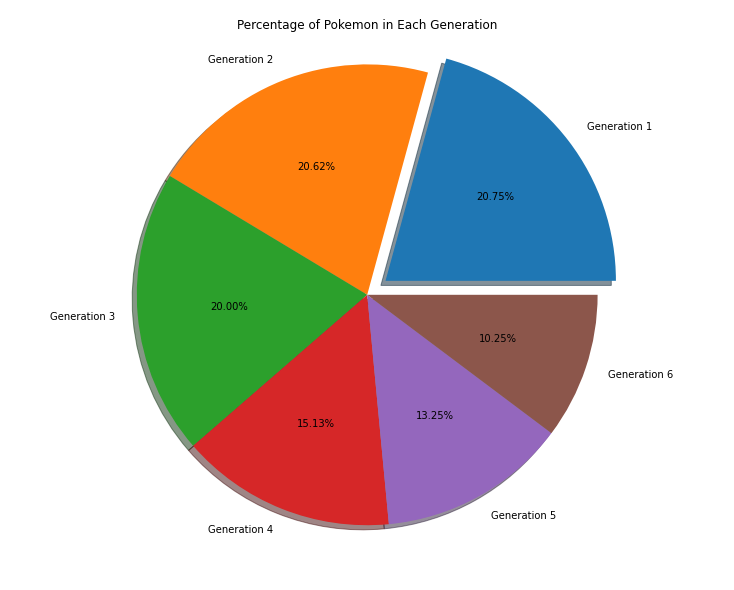

In [19]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle("Percentage of Pokemon in Each Generation")
ax3 = fig.add_axes([0, 0, 1, 1])
# "explodes" 1st slice
explode = (0.1, 0, 0, 0, 0, 0) 
ax3.axis('equal')

plt.pie(gen_counts, labels = gens, autopct='%1.2f%%', shadow=True, explode=explode)

#### Looking into the Legendary Pokemons.
Legendary Pokemon are extremely powerful!

In [20]:
legendaries = dict(pokemon['Legendary'].value_counts())
legendaries

{False: 735, True: 65}

In [21]:
legendaries_counts = legendaries.values()
legendaries_counts

dict_values([735, 65])

In [22]:
legendaries_class = legendaries.keys()
legendaries_class

dict_keys([False, True])

In [23]:
legendaries_class2 = ['Not Legendary', 'Legendary']
legendaries_class2

['Not Legendary', 'Legendary']

([<matplotlib.patches.Wedge at 0x7f7e3c798b80>,
 [Text(-1.2578788077755538, 0.328239097228151, 'Not Legendary'),
  Text(1.064358978192714, -0.27774082440390685, 'Legendary')],
 [Text(-0.7740792663234177, 0.20199329060193905, '91.87%'),
  Text(0.5805594426505712, -0.1514949951294037, '8.12%')])

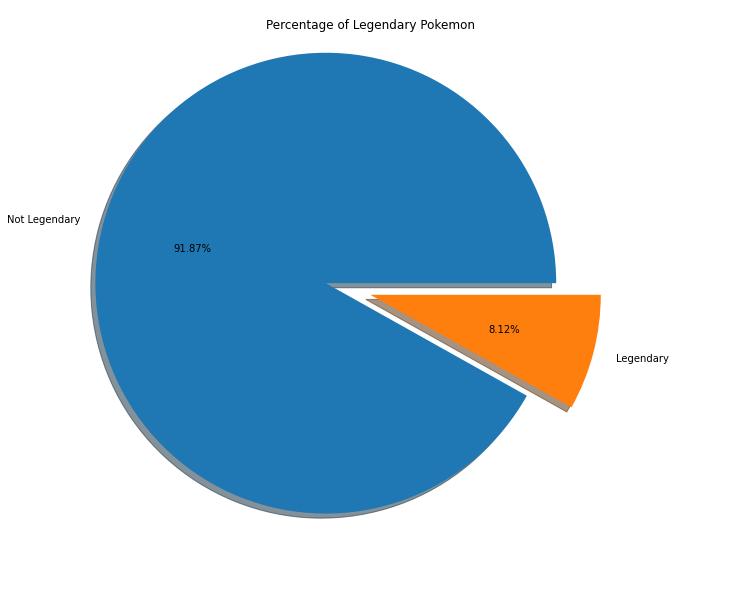

In [24]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle("Percentage of Legendary Pokemon")
ax4 = fig.add_axes([0, 0, 1, 1])
# "explodes" 1st slice
explode = (0.2, 0) 
ax4.axis('equal')

plt.pie(legendaries_counts, labels = legendaries_class2, autopct='%1.2f%%', shadow=True, explode=explode)

In [25]:
pokemon

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,True
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,True
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,True


#### Correlation Between Variables

In [26]:
# We excluded the  '#' column since it's just the index.
pokemon[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary']].corr()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
HP,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.058683,0.273620
Attack,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.051451,0.345408
Defense,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.042419,0.246377
Sp. Atk,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.036437,0.448907
Sp. Def,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.028486,0.363937
Speed,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,-0.023121,0.326715
Generation,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,1.000000,0.079794
Legendary,0.273620,0.345408,0.246377,0.448907,0.363937,0.326715,0.079794,1.000000


#### Dealing with Null Values
Some of the Pokemons do not have 2 types so that have null values.

In [27]:
pokemon['Type 2']

0      Poison
1      Poison
2      Poison
3      Poison
4         NaN
        ...  
795     Fairy
796     Fairy
797     Ghost
798      Dark
799     Water
Name: Type 2, Length: 800, dtype: object

In [28]:
# We will replace it with a category 'NA'
pokemon['Type 2'] = pokemon['Type 2'].fillna('NA')

In [29]:
pokemon['Type 2'].isna().unique()

array([False])

In [30]:
# We have a missing Pokemon name. I googled the pokedex and discovered we were missing Primeape.
pokemon[pokemon['Name'].isna()]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
62,63,NaN,Fighting,NA,65,105,60,60,70,95,1,False


In [31]:
pokemon.head(65)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NA,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
60,61,Golduck,Water,NA,80,82,78,95,80,85,1,False
61,62,Mankey,Fighting,NA,40,80,35,35,45,70,1,False
62,63,NaN,Fighting,NA,65,105,60,60,70,95,1,False
63,64,Growlithe,Fire,NA,55,70,45,70,50,60,1,False


In [32]:
pokemon['Name'][62] = 'Primeape'

/tmp/ipykernel_240/1148407592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pokemon['Name'][62] = 'Primeape'


In [33]:
pokemon.head(65)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NA,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
60,61,Golduck,Water,NA,80,82,78,95,80,85,1,False
61,62,Mankey,Fighting,NA,40,80,35,35,45,70,1,False
62,63,Primeape,Fighting,NA,65,105,60,60,70,95,1,False
63,64,Growlithe,Fire,NA,55,70,45,70,50,60,1,False


In [34]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      800 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


In [35]:
combats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   First_pokemon   50000 non-null  int64
 1   Second_pokemon  50000 non-null  int64
 2   Winner          50000 non-null  int64
dtypes: int64(3)
memory usage: 1.1 MB


In [36]:
pokemon

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NA,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,True
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,True
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,True


#### Exploring the Numerical Variables

In [37]:
pokemon[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].describe()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


In [38]:
# f = plt.figure()
# f.set_figwidth(50)
# f.set_figheight(10)

# ax = sns.lineplot(x='Name', y='HP', data= pokemon, 
#               color = 'red')
# ax.set(xlabel='Pokemon Generation', ylabel='Average HP')

# plt.title('Average HP of Each Pokemon Generation')
# plt.show()

#### Exporing the Numerical Variables Between Generations

In [39]:
gen1 = pokemon[pokemon['Generation'] == 1]
gen1

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NA,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
161,162,Dragonite,Dragon,Flying,91,134,95,100,100,80,1,False
162,163,Mewtwo,Psychic,NA,106,110,90,154,90,130,1,True
163,164,Mega Mewtwo X,Psychic,Fighting,106,190,100,154,100,130,1,True
164,165,Mega Mewtwo Y,Psychic,NA,106,150,70,194,120,140,1,True


In [40]:
gen2 = pokemon[pokemon['Generation'] == 2]
gen2

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
166,167,Chikorita,Grass,NA,45,49,65,49,65,45,2,False
167,168,Bayleef,Grass,NA,60,62,80,63,80,60,2,False
168,169,Meganium,Grass,NA,80,82,100,83,100,80,2,False
169,170,Cyndaquil,Fire,NA,39,52,43,60,50,65,2,False
170,171,Quilava,Fire,NA,58,64,58,80,65,80,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...
267,268,Tyranitar,Rock,Dark,100,134,110,95,100,61,2,False
268,269,Mega Tyranitar,Rock,Dark,100,164,150,95,120,71,2,False
269,270,Lugia,Psychic,Flying,106,90,130,90,154,110,2,True
270,271,Ho-oh,Fire,Flying,106,130,90,110,154,90,2,True


In [41]:
gen3 = pokemon[pokemon['Generation'] == 3]
gen3

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
272,273,Treecko,Grass,NA,40,45,35,65,55,70,3,False
273,274,Grovyle,Grass,NA,50,65,45,85,65,95,3,False
274,275,Sceptile,Grass,NA,70,85,65,105,85,120,3,False
275,276,Mega Sceptile,Grass,Dragon,70,110,75,145,85,145,3,False
276,277,Torchic,Fire,NA,45,60,40,70,50,45,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...
427,428,Jirachi,Steel,Psychic,100,100,100,100,100,100,3,True
428,429,Deoxys Normal Forme,Psychic,NA,50,150,50,150,50,150,3,True
429,430,DeoxysAttack Forme,Psychic,NA,50,180,20,180,20,150,3,True
430,431,Deoxys Defense Forme,Psychic,NA,50,70,160,70,160,90,3,True


In [42]:
gen4 = pokemon[pokemon['Generation'] == 4]
gen4

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
432,433,Turtwig,Grass,NA,55,68,64,45,55,31,4,False
433,434,Grotle,Grass,NA,75,89,85,55,65,36,4,False
434,435,Torterra,Grass,Ground,95,109,105,75,85,56,4,False
435,436,Chimchar,Fire,NA,44,58,44,58,44,61,4,False
436,437,Monferno,Fire,Fighting,64,78,52,78,52,81,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...
548,549,Manaphy,Water,NA,100,100,100,100,100,100,4,False
549,550,Darkrai,Dark,NA,70,90,90,135,90,125,4,True
550,551,Shaymin Land Forme,Grass,NA,100,100,100,100,100,100,4,True
551,552,Shaymin Sky Forme,Grass,Flying,100,103,75,120,75,127,4,True


In [43]:
gen5 = pokemon[pokemon['Generation'] == 5]
gen5

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
553,554,Victini,Psychic,Fire,100,100,100,100,100,100,5,True
554,555,Snivy,Grass,NA,45,45,55,45,55,63,5,False
555,556,Servine,Grass,NA,60,60,75,60,75,83,5,False
556,557,Serperior,Grass,NA,75,75,95,75,95,113,5,False
557,558,Tepig,Fire,NA,65,63,45,45,45,45,5,False
...,...,...,...,...,...,...,...,...,...,...,...,...
713,714,Keldeo Ordinary Forme,Water,Fighting,91,72,90,129,90,108,5,False
714,715,Keldeo Resolute Forme,Water,Fighting,91,72,90,129,90,108,5,False
715,716,Meloetta Aria Forme,Normal,Psychic,100,77,77,128,128,90,5,False
716,717,Meloetta Pirouette Forme,Normal,Fighting,100,128,90,77,77,128,5,False


In [44]:
gen6 = pokemon[pokemon['Generation'] == 6]
gen6

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
718,719,Chespin,Grass,NA,56,61,65,48,45,38,6,False
719,720,Quilladin,Grass,NA,61,78,95,56,58,57,6,False
720,721,Chesnaught,Grass,Fighting,88,107,122,74,75,64,6,False
721,722,Fennekin,Fire,NA,40,45,40,62,60,60,6,False
722,723,Braixen,Fire,NA,59,59,58,90,70,73,6,False
...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,True
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,True
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,True


In [45]:
gen1_stats = gen1[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].describe()
gen1_stats

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,65.819277,76.638554,70.861446,71.819277,69.090361,72.584337
std,28.153968,30.744727,28.641336,34.439106,25.505275,29.675857
min,10.000000,5.000000,5.000000,15.000000,20.000000,15.000000
25%,46.500000,55.000000,50.000000,45.000000,50.000000,50.000000
50%,62.000000,75.000000,66.000000,65.000000,70.000000,70.000000
75%,80.000000,95.000000,85.000000,95.000000,85.000000,92.250000
max,250.000000,190.000000,180.000000,194.000000,130.000000,150.000000


In [46]:
gen2_stats = gen2[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].describe()
gen2_stats

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,71.207547,72.028302,73.386792,65.943396,73.905660,61.811321
std,30.589359,32.708658,39.233749,27.814977,31.534268,27.263132
min,20.000000,10.000000,10.000000,10.000000,20.000000,5.000000
25%,51.250000,50.000000,45.750000,40.000000,55.000000,40.000000
50%,70.000000,73.500000,70.000000,65.000000,65.000000,60.500000
75%,88.750000,90.000000,90.000000,84.500000,95.000000,85.000000
max,255.000000,185.000000,230.000000,165.000000,230.000000,130.000000


In [47]:
gen3_stats = gen3[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].describe()
gen3_stats

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,160.000000,160.000000,160.000000,160.00000,160.000000,160.000000
mean,66.543750,81.625000,74.100000,75.80625,71.225000,66.925000
std,24.059634,36.593767,35.222599,35.40751,31.039628,31.331972
min,1.000000,15.000000,20.000000,10.00000,20.000000,10.000000
25%,50.000000,54.000000,50.000000,50.00000,50.000000,47.250000
50%,65.000000,75.000000,67.500000,70.00000,65.000000,65.000000
75%,80.000000,100.000000,90.000000,95.00000,87.000000,86.250000
max,170.000000,180.000000,230.000000,180.00000,200.000000,180.000000


In [48]:
gen4_stats = gen4[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].describe()
gen4_stats

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,73.082645,82.867769,78.132231,76.404959,77.190083,71.338843
std,25.113604,32.780569,30.145741,31.907047,27.498883,28.475005
min,20.000000,5.000000,5.000000,10.000000,30.000000,5.000000
25%,55.000000,62.000000,51.000000,54.000000,55.000000,46.000000
50%,70.000000,80.000000,72.000000,71.000000,75.000000,77.000000
75%,85.000000,103.000000,105.000000,100.000000,100.000000,91.000000
max,150.000000,170.000000,168.000000,150.000000,150.000000,135.000000


In [49]:
gen5_stats = gen5[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].describe()
gen5_stats

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,71.787879,82.066667,72.327273,71.987879,68.739394,68.078788
std,22.407748,30.365685,23.318883,31.889097,22.388721,28.726632
min,30.000000,25.000000,30.000000,15.000000,25.000000,10.000000
25%,55.000000,55.000000,55.000000,45.000000,50.000000,45.000000
50%,70.000000,80.000000,70.000000,65.000000,65.000000,65.000000
75%,85.000000,103.000000,90.000000,95.000000,85.000000,95.000000
max,165.000000,170.000000,145.000000,170.000000,135.000000,145.000000


In [50]:
gen6_stats = gen6[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].describe()
gen6_stats

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,68.268293,75.804878,76.682927,74.292683,74.890244,66.439024
std,20.907822,29.179495,31.370301,31.790785,30.086298,25.691954
min,38.000000,22.000000,33.000000,27.000000,25.000000,23.000000
25%,53.250000,53.250000,55.500000,50.000000,55.000000,48.250000
50%,65.000000,69.500000,70.000000,65.000000,70.500000,60.000000
75%,80.000000,94.250000,89.500000,95.250000,89.000000,80.000000
max,126.000000,160.000000,184.000000,170.000000,154.000000,126.000000


In [51]:
# Getting the count of the HP column for Gen 6. (iloc)
gen6_stats.iloc[0, 0]

82.0

In [52]:
# Getting the mean of the HP column for Gen 6.
gen6_stats.loc['mean', 'HP']

68.26829268292683

In [53]:
gen6_stats.loc['mean', 'HP':'Defense']

HP         68.268293
Attack     75.804878
Defense    76.682927
Name: mean, dtype: float64

In [54]:
pd.DataFrame(gen6_stats.loc['mean', 'HP':'Defense'])

,mean
HP,68.268293
Attack,75.804878
Defense,76.682927


In [55]:
# Average of the HP for Each Generation
gen1_average_hp = gen1_stats.loc['mean', 'HP']
gen2_average_hp = gen2_stats.loc['mean', 'HP']
gen3_average_hp = gen3_stats.loc['mean', 'HP']
gen4_average_hp = gen4_stats.loc['mean', 'HP']
gen5_average_hp = gen5_stats.loc['mean', 'HP']
gen6_average_hp = gen6_stats.loc['mean', 'HP']

In [56]:
# Average of the Attack for Each Generation
gen1_average_attack = gen1_stats.loc['mean', 'Attack']
gen2_average_attack = gen2_stats.loc['mean', 'Attack']
gen3_average_attack = gen3_stats.loc['mean', 'Attack']
gen4_average_attack = gen4_stats.loc['mean', 'Attack']
gen5_average_attack = gen5_stats.loc['mean', 'Attack']
gen6_average_attack = gen6_stats.loc['mean', 'Attack']

In [57]:
# Average of the Defense for Each Generation
gen1_average_defense = gen1_stats.loc['mean', 'Defense']
gen2_average_defense = gen2_stats.loc['mean', 'Defense']
gen3_average_defense = gen3_stats.loc['mean', 'Defense']
gen4_average_defense = gen4_stats.loc['mean', 'Defense']
gen5_average_defense = gen5_stats.loc['mean', 'Defense']
gen6_average_defense = gen6_stats.loc['mean', 'Defense']

In [58]:
# Average of the Special Attack for Each Generation
gen1_average_sfatk = gen1_stats.loc['mean', 'Sp. Atk']
gen2_average_sfatk = gen2_stats.loc['mean', 'Sp. Atk']
gen3_average_sfatk = gen3_stats.loc['mean', 'Sp. Atk']
gen4_average_sfatk = gen4_stats.loc['mean', 'Sp. Atk']
gen5_average_sfatk = gen5_stats.loc['mean', 'Sp. Atk']
gen6_average_sfatk = gen6_stats.loc['mean', 'Sp. Atk']

In [59]:
# Average of the Special Defense for Each Generation
gen1_average_sfdef = gen1_stats.loc['mean', 'Sp. Def']
gen2_average_sfdef = gen2_stats.loc['mean', 'Sp. Def']
gen3_average_sfdef = gen3_stats.loc['mean', 'Sp. Def']
gen4_average_sfdef = gen4_stats.loc['mean', 'Sp. Def']
gen5_average_sfdef = gen5_stats.loc['mean', 'Sp. Def']
gen6_average_sfdef = gen6_stats.loc['mean', 'Sp. Def']

In [60]:
# Average of the Defense for Each Generation
gen1_average_speed = gen1_stats.loc['mean', 'Speed']
gen2_average_speed = gen2_stats.loc['mean', 'Speed']
gen3_average_speed = gen3_stats.loc['mean', 'Speed']
gen4_average_speed = gen4_stats.loc['mean', 'Speed']
gen5_average_speed = gen5_stats.loc['mean', 'Speed']
gen6_average_speed = gen6_stats.loc['mean', 'Speed']

In [61]:
poke_stats_dict = {1: [gen1_average_hp, gen1_average_attack, gen1_average_defense, gen1_average_sfatk, gen1_average_sfdef, gen1_average_speed], 
                  2: [gen2_average_hp, gen2_average_attack, gen2_average_defense, gen2_average_sfatk, gen2_average_sfdef, gen2_average_speed], 
                  3: [gen3_average_hp, gen3_average_attack, gen3_average_defense, gen3_average_sfatk, gen3_average_sfdef, gen3_average_speed], 
                  4: [gen4_average_hp, gen4_average_attack, gen4_average_defense, gen4_average_sfatk, gen4_average_sfdef, gen4_average_speed], 
                  5: [gen5_average_hp, gen5_average_attack, gen5_average_defense, gen5_average_sfatk, gen5_average_sfdef, gen5_average_speed], 
                  6: [gen6_average_hp, gen6_average_attack, gen6_average_defense, gen6_average_sfatk, gen6_average_sfdef, gen6_average_speed]}

In [62]:
poke_stats_dict

{1: [65.81927710843374,
  76.63855421686748,
  70.86144578313252,
  71.81927710843374,
  69.09036144578313,
  72.58433734939759],
 2: [71.20754716981132,
  72.02830188679245,
  73.38679245283019,
  65.94339622641509,
  73.90566037735849,
  61.81132075471698],
 3: [66.54375, 81.625, 74.1, 75.80625, 71.225, 66.925],
 4: [73.08264462809917,
  82.86776859504133,
  78.13223140495867,
  76.40495867768595,
  77.1900826446281,
  71.33884297520662],
 5: [71.78787878787878,
  82.06666666666666,
  72.32727272727273,
  71.98787878787878,
  68.73939393939393,
  68.07878787878788],
 6: [68.26829268292683,
  75.8048780487805,
  76.6829268292683,
  74.29268292682927,
  74.89024390243902,
  66.4390243902439]}

In [63]:
tuple(poke_stats_dict.keys())

(1, 2, 3, 4, 5, 6)

In [64]:
poke_stats_dict.get(1)

[65.81927710843374,
 76.63855421686748,
 70.86144578313252,
 71.81927710843374,
 69.09036144578313,
 72.58433734939759]

In [65]:
poke_stats_dict.items()

dict_items([(1, [65.81927710843374, 76.63855421686748, 70.86144578313252, 71.81927710843374, 69.09036144578313, 72.58433734939759]), (2, [71.20754716981132, 72.02830188679245, 73.38679245283019, 65.94339622641509, 73.90566037735849, 61.81132075471698]), (3, [66.54375, 81.625, 74.1, 75.80625, 71.225, 66.925]), (4, [73.08264462809917, 82.86776859504133, 78.13223140495867, 76.40495867768595, 77.1900826446281, 71.33884297520662]), (5, [71.78787878787878, 82.06666666666666, 72.32727272727273, 71.98787878787878, 68.73939393939393, 68.07878787878788]), (6, [68.26829268292683, 75.8048780487805, 76.6829268292683, 74.29268292682927, 74.89024390243902, 66.4390243902439])])

In [66]:
def extract_stats(stat_position):
    lst = []
    for i in range(len(list(poke_stats_dict.keys()))):
        lst.append(list(poke_stats_dict.values())[i][stat_position])
    return lst

In [67]:
hp_average_list = extract_stats(0)
hp_average_list

[65.81927710843374,
 71.20754716981132,
 66.54375,
 73.08264462809917,
 71.78787878787878,
 68.26829268292683]

In [68]:
attack_average_list = extract_stats(1)
attack_average_list

[76.63855421686748,
 72.02830188679245,
 81.625,
 82.86776859504133,
 82.06666666666666,
 75.8048780487805]

In [69]:
defense_average_list = extract_stats(2)
defense_average_list

[70.86144578313252,
 73.38679245283019,
 74.1,
 78.13223140495867,
 72.32727272727273,
 76.6829268292683]

In [70]:
spatk_average_list = extract_stats(3)
spatk_average_list

[71.81927710843374,
 65.94339622641509,
 75.80625,
 76.40495867768595,
 71.98787878787878,
 74.29268292682927]

In [71]:
spdef_average_list = extract_stats(4)
spdef_average_list

[69.09036144578313,
 73.90566037735849,
 71.225,
 77.1900826446281,
 68.73939393939393,
 74.89024390243902]

In [72]:
speed_average_list = extract_stats(5)
speed_average_list

[72.58433734939759,
 61.81132075471698,
 66.925,
 71.33884297520662,
 68.07878787878788,
 66.4390243902439]

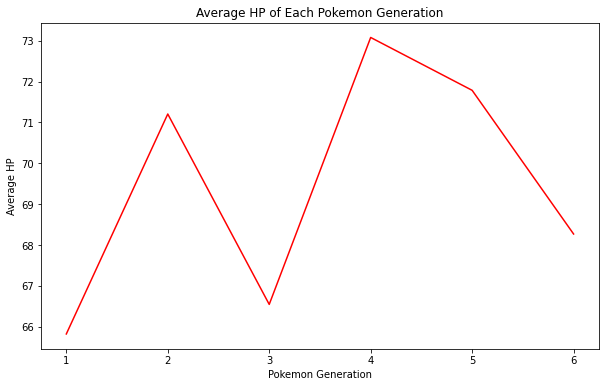

In [73]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(6)

ax = sns.lineplot(x = tuple(poke_stats_dict.keys()), y = tuple(hp_average_list), data= poke_stats_dict, 
              color = 'red')
ax.set(xlabel='Pokemon Generation', ylabel='Average HP')

plt.title('Average HP of Each Pokemon Generation')
plt.show()

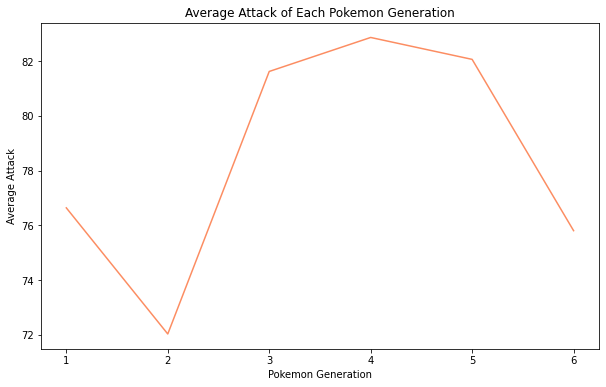

In [74]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(6)

ax = sns.lineplot(x=tuple(poke_stats_dict.keys()), y = tuple(attack_average_list), data= poke_stats_dict, 
              color = sns.color_palette("Set2")[1])
ax.set(xlabel='Pokemon Generation', ylabel='Average Attack')

plt.title('Average Attack of Each Pokemon Generation')
plt.show()

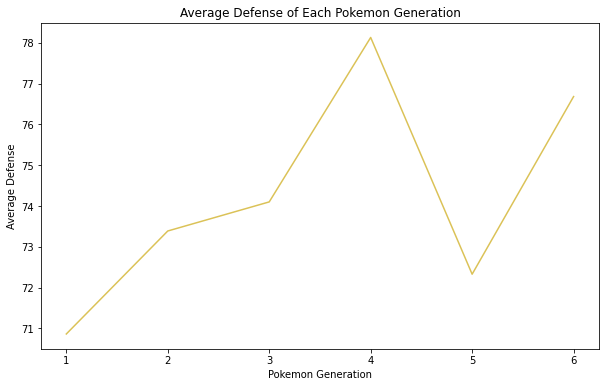

In [75]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(6)

ax = sns.lineplot(x=tuple(poke_stats_dict.keys()), y = tuple(defense_average_list), data= poke_stats_dict, 
              color = sns.color_palette("hls", 8)[1])
ax.set(xlabel='Pokemon Generation', ylabel='Average Defense')

plt.title('Average Defense of Each Pokemon Generation')
plt.show()

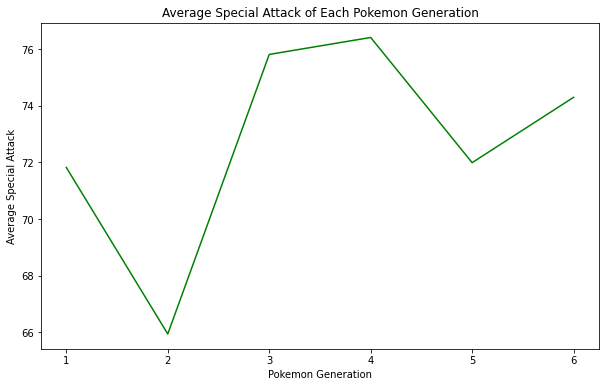

In [76]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(6)

ax = sns.lineplot(x=tuple(poke_stats_dict.keys()), y = tuple(spatk_average_list), data= poke_stats_dict, 
              color = 'green')
ax.set(xlabel='Pokemon Generation', ylabel='Average Special Attack')

plt.title('Average Special Attack of Each Pokemon Generation')
plt.show()

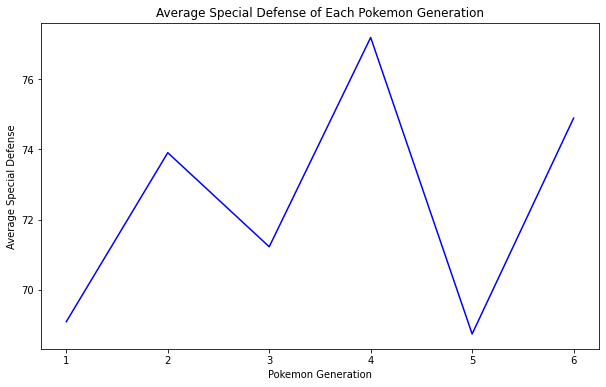

In [77]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(6)

ax = sns.lineplot(x=tuple(poke_stats_dict.keys()), y = tuple(spdef_average_list), data= poke_stats_dict, 
              color = 'blue')
ax.set(xlabel='Pokemon Generation', ylabel='Average Special Defense')

plt.title('Average Special Defense of Each Pokemon Generation')
plt.show()

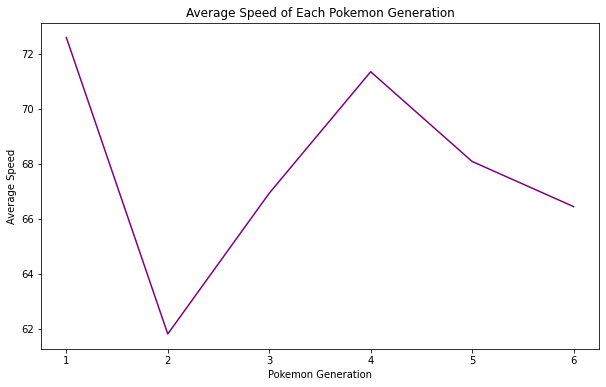

In [78]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(6)

ax = sns.lineplot(x=tuple(poke_stats_dict.keys()), y = tuple(speed_average_list), data= poke_stats_dict, 
              color = 'purple')
ax.set(xlabel='Pokemon Generation', ylabel='Average Speed')

plt.title('Average Speed of Each Pokemon Generation')
plt.show()

#### Creating Dummy Variables for Categorical Variables

In [79]:
categorical_cols = ['Type 1', 'Type 2', 'Generation', 'Legendary']
categorical_cols

['Type 1', 'Type 2', 'Generation', 'Legendary']

In [80]:
pokemon_enc = pd.get_dummies(pokemon, columns = categorical_cols)
pokemon_enc

,#,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type 1_Bug,Type 1_Dark,...,Type 2_Steel,Type 2_Water,Generation_1,Generation_2,Generation_3,Generation_4,Generation_5,Generation_6,Legendary_False,Legendary_True
0,1,Bulbasaur,45,49,49,65,65,45,0,0,...,0,0,1,0,0,0,0,0,1,0
1,2,Ivysaur,60,62,63,80,80,60,0,0,...,0,0,1,0,0,0,0,0,1,0
2,3,Venusaur,80,82,83,100,100,80,0,0,...,0,0,1,0,0,0,0,0,1,0
3,4,Mega Venusaur,80,100,123,122,120,80,0,0,...,0,0,1,0,0,0,0,0,1,0
4,5,Charmander,39,52,43,60,50,65,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,50,100,150,100,150,50,0,0,...,0,0,0,0,0,0,0,1,0,1
796,797,Mega Diancie,50,160,110,160,110,110,0,0,...,0,0,0,0,0,0,0,1,0,1
797,798,Hoopa Confined,80,110,60,150,130,70,0,0,...,0,0,0,0,0,0,0,1,0,1
798,799,Hoopa Unbound,80,160,60,170,130,80,0,0,...,0,0,0,0,0,0,0,1,0,1


In [81]:
pokemon_enc.iloc[265: 269, :]

,#,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type 1_Bug,Type 1_Dark,...,Type 2_Steel,Type 2_Water,Generation_1,Generation_2,Generation_3,Generation_4,Generation_5,Generation_6,Legendary_False,Legendary_True
265,266,Larvitar,50,64,50,45,50,41,0,0,...,0,0,0,1,0,0,0,0,1,0
266,267,Pupitar,70,84,70,65,70,51,0,0,...,0,0,0,1,0,0,0,0,1,0
267,268,Tyranitar,100,134,110,95,100,61,0,0,...,0,0,0,1,0,0,0,0,1,0
268,269,Mega Tyranitar,100,164,150,95,120,71,0,0,...,0,0,0,1,0,0,0,0,1,0


#### Using FeatureHasher

In [82]:
# Convert "Legendary" column, False is converted to 0 and True is converted to 1.
pokemon["Legendary"] = pokemon["Legendary"].astype(int)

Use FeatureHasher convert columns “Type 1” and “Type 2” into numerical values. This solves the problem of having a large number of columns (when the number of categories is extremely large) due to one-hot encoding.

In [83]:
h1 = FeatureHasher(n_features=5, input_type='string')
h2 = FeatureHasher(n_features=5, input_type='string')
d1 = h1.fit_transform(pokemon["Type 1"])
d2 = h2.fit_transform(pokemon["Type 2"])

In [84]:
# Convert to dataframe
d1 = pd.DataFrame(data=d1.toarray())
d2 = pd.DataFrame(data=d2.toarray())

In [85]:
d1

,0,1,2,3,4
0,2.0,0.0,0.0,0.0,-1.0
1,2.0,0.0,0.0,0.0,-1.0
2,2.0,0.0,0.0,0.0,-1.0
3,2.0,0.0,0.0,0.0,-1.0
4,1.0,-1.0,0.0,-1.0,1.0
...,...,...,...,...,...
795,0.0,-1.0,-1.0,1.0,1.0
796,0.0,-1.0,-1.0,1.0,1.0
797,-1.0,-2.0,-2.0,0.0,0.0
798,-1.0,-2.0,-2.0,0.0,0.0


In [86]:
d2

,0,1,2,3,4
0,0.0,-2.0,0.0,2.0,-2.0
1,0.0,-2.0,0.0,2.0,-2.0
2,0.0,-2.0,0.0,2.0,-2.0
3,0.0,-2.0,0.0,2.0,-2.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
795,2.0,-1.0,0.0,-1.0,1.0
796,2.0,-1.0,0.0,-1.0,1.0
797,-1.0,0.0,0.0,1.0,-1.0
798,2.0,0.0,0.0,0.0,0.0


In [87]:
# Drop Type 1 and Type 2 column from Pokemon dataset and concatenate the above two dataframes which represent the Pokemon Types.
pokemon_enc = pokemon.drop(columns = ["Type 1", "Type 2"], axis=1)
pokemon_enc = pd.concat([pokemon_enc, d1, d2], axis=1)
pokemon_enc

,#,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,0,1,2,3,4,0,1,2,3,4
0,1,Bulbasaur,45,49,49,65,65,45,1,0,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0
1,2,Ivysaur,60,62,63,80,80,60,1,0,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0
2,3,Venusaur,80,82,83,100,100,80,1,0,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0
3,4,Mega Venusaur,80,100,123,122,120,80,1,0,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0
4,5,Charmander,39,52,43,60,50,65,1,0,1.0,-1.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,50,100,150,100,150,50,6,1,0.0,-1.0,-1.0,1.0,1.0,2.0,-1.0,0.0,-1.0,1.0
796,797,Mega Diancie,50,160,110,160,110,110,6,1,0.0,-1.0,-1.0,1.0,1.0,2.0,-1.0,0.0,-1.0,1.0
797,798,Hoopa Confined,80,110,60,150,130,70,6,1,-1.0,-2.0,-2.0,0.0,0.0,-1.0,0.0,0.0,1.0,-1.0
798,799,Hoopa Unbound,80,160,60,170,130,80,6,1,-1.0,-2.0,-2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


#### We will now combine the two datasets together.
Our goal is to concatenate the features from the 'pokemon' dataset to the 'combats' dataset. We will get the stats, whether or not the pokemon is a legendary and the generation its from for both the losing pokemon and the winner pokemon.

In [88]:
# Sampling 5000(10% of data) because our computer CANNOT HANDLE TOO MUCH DATA :(
# combats2 = combats.copy(deep = True).sample(5000)
combats2 = combats.copy(deep = True)
combats2

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151
...,...,...,...
49995,707,126,707
49996,589,664,589
49997,303,368,368
49998,109,89,109


In [89]:
# Merging the First Pokemon with the "pokemon" dataset

merging_first_pokemon = combats2.merge(pokemon_enc, how='left', left_on=['First_pokemon'], right_on=['#'])
merging_first_pokemon

,First_pokemon,Second_pokemon,Winner,#,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,...,0,1,2,3,4,0,1,2,3,4
0,266,298,298,266,Larvitar,50,64,50,45,50,...,0.0,-1.0,-1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1,702,701,701,702,Virizion,91,90,72,90,129,...,2.0,0.0,0.0,0.0,-1.0,-1.0,-2.0,-2.0,-1.0,-2.0
2,191,668,668,191,Togetic,55,40,85,80,105,...,2.0,-1.0,0.0,-1.0,1.0,0.0,-1.0,0.0,-1.0,0.0
3,237,683,683,237,Slugma,40,40,40,70,40,...,1.0,-1.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,151,231,151,151,Omastar,70,60,125,115,70,...,0.0,-1.0,-1.0,1.0,1.0,2.0,0.0,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,707,126,707,707,Reshiram,100,120,100,150,120,...,2.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
49996,589,664,589,589,Drilbur,60,85,40,30,45,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
49997,303,368,368,303,Pelipper,60,50,100,85,70,...,2.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
49998,109,89,109,109,Voltorb,40,30,50,55,55,...,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
# Function to rename our columns for us so we can distinguish beteen the first pokemon's stats and the second one's.
def update_column_names(data, added_string):
    for i in range(len(data.columns)):
        data.columns.values[i] = str(data.columns.values[i]) + str(added_string)
    return data

In [91]:
update_column_names(merging_first_pokemon, ' 1st')

,First_pokemon 1st,Second_pokemon 1st,Winner 1st,# 1st,Name 1st,HP 1st,Attack 1st,Defense 1st,Sp. Atk 1st,Sp. Def 1st,...,0 1st,1 1st,2 1st,3 1st,4 1st,0 1st,1 1st,2 1st,3 1st,4 1st
0,266,298,298,266,Larvitar,50,64,50,45,50,...,0.0,-1.0,-1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1,702,701,701,702,Virizion,91,90,72,90,129,...,2.0,0.0,0.0,0.0,-1.0,-1.0,-2.0,-2.0,-1.0,-2.0
2,191,668,668,191,Togetic,55,40,85,80,105,...,2.0,-1.0,0.0,-1.0,1.0,0.0,-1.0,0.0,-1.0,0.0
3,237,683,683,237,Slugma,40,40,40,70,40,...,1.0,-1.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,151,231,151,151,Omastar,70,60,125,115,70,...,0.0,-1.0,-1.0,1.0,1.0,2.0,0.0,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,707,126,707,707,Reshiram,100,120,100,150,120,...,2.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,0.0,-1.0,1.0
49996,589,664,589,589,Drilbur,60,85,40,30,45,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
49997,303,368,368,303,Pelipper,60,50,100,85,70,...,2.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
49998,109,89,109,109,Voltorb,40,30,50,55,55,...,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
merging_first_pokemon.columns

Index(['First_pokemon 1st', 'Second_pokemon 1st', 'Winner 1st', '# 1st',
       'Name 1st', 'HP 1st', 'Attack 1st', 'Defense 1st', 'Sp. Atk 1st',
       'Sp. Def 1st', 'Speed 1st', 'Generation 1st', 'Legendary 1st', '0 1st',
       '1 1st', '2 1st', '3 1st', '4 1st', '0 1st', '1 1st', '2 1st', '3 1st',
       '4 1st'],
      dtype='object')

In [93]:
# Merging the Second Pokemon with the "pokemon" dataset
merging_second_pokemon = combats2.merge(pokemon_enc, how='left', left_on=['Second_pokemon'], right_on=['#'])
merging_second_pokemon

,First_pokemon,Second_pokemon,Winner,#,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,...,0,1,2,3,4,0,1,2,3,4
0,266,298,298,298,Nuzleaf,70,70,40,60,40,...,2.0,0.0,0.0,0.0,-1.0,2.0,0.0,0.0,0.0,0.0
1,702,701,701,701,Terrakion,91,129,90,72,90,...,0.0,-1.0,-1.0,1.0,1.0,-1.0,-2.0,-2.0,-1.0,-2.0
2,191,668,668,668,Beheeyem,75,75,75,125,95,...,-1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,237,683,683,683,Druddigon,77,120,90,60,90,...,2.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
4,151,231,151,231,Shuckle,20,10,230,10,230,...,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,707,126,707,126,Horsea,30,40,70,70,25,...,2.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
49996,589,664,589,664,Tynamo,35,55,40,45,40,...,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,303,368,368,368,Zangoose,73,115,60,60,60,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,109,89,109,89,Magnemite,25,35,70,95,55,...,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0


In [94]:
update_column_names(merging_second_pokemon, ' 2nd')

,First_pokemon 2nd,Second_pokemon 2nd,Winner 2nd,# 2nd,Name 2nd,HP 2nd,Attack 2nd,Defense 2nd,Sp. Atk 2nd,Sp. Def 2nd,...,0 2nd,1 2nd,2 2nd,3 2nd,4 2nd,0 2nd,1 2nd,2 2nd,3 2nd,4 2nd
0,266,298,298,298,Nuzleaf,70,70,40,60,40,...,2.0,0.0,0.0,0.0,-1.0,2.0,0.0,0.0,0.0,0.0
1,702,701,701,701,Terrakion,91,129,90,72,90,...,0.0,-1.0,-1.0,1.0,1.0,-1.0,-2.0,-2.0,-1.0,-2.0
2,191,668,668,668,Beheeyem,75,75,75,125,95,...,-1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,237,683,683,683,Druddigon,77,120,90,60,90,...,2.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
4,151,231,151,231,Shuckle,20,10,230,10,230,...,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,707,126,707,126,Horsea,30,40,70,70,25,...,2.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
49996,589,664,589,664,Tynamo,35,55,40,45,40,...,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,303,368,368,368,Zangoose,73,115,60,60,60,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,109,89,109,89,Magnemite,25,35,70,95,55,...,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0


In [95]:
merging_second_pokemon = merging_second_pokemon.drop(columns=['First_pokemon 2nd', 'Second_pokemon 2nd', 
                                                             'Winner 2nd', '# 2nd', 'Name 2nd'])
merging_second_pokemon

,HP 2nd,Attack 2nd,Defense 2nd,Sp. Atk 2nd,Sp. Def 2nd,Speed 2nd,Generation 2nd,Legendary 2nd,0 2nd,1 2nd,2 2nd,3 2nd,4 2nd,0 2nd,1 2nd,2 2nd,3 2nd,4 2nd
0,70,70,40,60,40,60,3,0,2.0,0.0,0.0,0.0,-1.0,2.0,0.0,0.0,0.0,0.0
1,91,129,90,72,90,108,5,1,0.0,-1.0,-1.0,1.0,1.0,-1.0,-2.0,-2.0,-1.0,-2.0
2,75,75,75,125,95,40,5,0,-1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,77,120,90,60,90,48,5,0,2.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
4,20,10,230,10,230,5,2,0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,30,40,70,70,25,60,1,0,2.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
49996,35,55,40,45,40,60,5,0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,73,115,60,60,60,90,3,0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,25,35,70,95,55,45,1,0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0


#### Combining Both Merged Datasets

In [96]:
merged_both_pokemon = pd.concat([merging_first_pokemon, merging_second_pokemon], axis=1, join="inner")
merged_both_pokemon

,First_pokemon 1st,Second_pokemon 1st,Winner 1st,# 1st,Name 1st,HP 1st,Attack 1st,Defense 1st,Sp. Atk 1st,Sp. Def 1st,...,0 2nd,1 2nd,2 2nd,3 2nd,4 2nd,0 2nd,1 2nd,2 2nd,3 2nd,4 2nd
0,266,298,298,266,Larvitar,50,64,50,45,50,...,2.0,0.0,0.0,0.0,-1.0,2.0,0.0,0.0,0.0,0.0
1,702,701,701,702,Virizion,91,90,72,90,129,...,0.0,-1.0,-1.0,1.0,1.0,-1.0,-2.0,-2.0,-1.0,-2.0
2,191,668,668,191,Togetic,55,40,85,80,105,...,-1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,237,683,683,237,Slugma,40,40,40,70,40,...,2.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
4,151,231,151,151,Omastar,70,60,125,115,70,...,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,707,126,707,707,Reshiram,100,120,100,150,120,...,2.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
49996,589,664,589,589,Drilbur,60,85,40,30,45,...,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,303,368,368,303,Pelipper,60,50,100,85,70,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,109,89,109,109,Voltorb,40,30,50,55,55,...,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0


In [97]:
# Renaming the first 3 columns since we removed the duplicates
merged_both_pokemon = merged_both_pokemon.rename(columns={'First_pokemon 1st': 'First_pokemon', 
                                    'Second_pokemon 1st': 'Second_pokemon', 
                                   'Winner 1st': 'Winner'})

In [98]:
merged_both_pokemon = merged_both_pokemon.drop(columns=['# 1st', 'Name 1st'], axis=1)
merged_both_pokemon

,First_pokemon,Second_pokemon,Winner,HP 1st,Attack 1st,Defense 1st,Sp. Atk 1st,Sp. Def 1st,Speed 1st,Generation 1st,...,0 2nd,1 2nd,2 2nd,3 2nd,4 2nd,0 2nd,1 2nd,2 2nd,3 2nd,4 2nd
0,266,298,298,50,64,50,45,50,41,2,...,2.0,0.0,0.0,0.0,-1.0,2.0,0.0,0.0,0.0,0.0
1,702,701,701,91,90,72,90,129,108,5,...,0.0,-1.0,-1.0,1.0,1.0,-1.0,-2.0,-2.0,-1.0,-2.0
2,191,668,668,55,40,85,80,105,40,2,...,-1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,237,683,683,40,40,40,70,40,20,2,...,2.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
4,151,231,151,70,60,125,115,70,55,1,...,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,707,126,707,100,120,100,150,120,90,5,...,2.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
49996,589,664,589,60,85,40,30,45,68,5,...,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,303,368,368,60,50,100,85,70,65,3,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,109,89,109,40,30,50,55,55,100,1,...,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0


In [99]:
merged_both_pokemon.columns

Index(['First_pokemon', 'Second_pokemon', 'Winner', 'HP 1st', 'Attack 1st',
       'Defense 1st', 'Sp. Atk 1st', 'Sp. Def 1st', 'Speed 1st',
       'Generation 1st', 'Legendary 1st', '0 1st', '1 1st', '2 1st', '3 1st',
       '4 1st', '0 1st', '1 1st', '2 1st', '3 1st', '4 1st', 'HP 2nd',
       'Attack 2nd', 'Defense 2nd', 'Sp. Atk 2nd', 'Sp. Def 2nd', 'Speed 2nd',
       'Generation 2nd', 'Legendary 2nd', '0 2nd', '1 2nd', '2 2nd', '3 2nd',
       '4 2nd', '0 2nd', '1 2nd', '2 2nd', '3 2nd', '4 2nd'],
      dtype='object')

In [100]:
# Adding column of 0s and 1s to indicate as to whether or not the first pokemon won the fight. 
# We will turn this into a classification problem.

merged_both_pokemon['First_Person_Won'] = (merged_both_pokemon['First_pokemon'] == merged_both_pokemon['Winner']).astype(int)

In [101]:
merged_both_pokemon

,First_pokemon,Second_pokemon,Winner,HP 1st,Attack 1st,Defense 1st,Sp. Atk 1st,Sp. Def 1st,Speed 1st,Generation 1st,...,1 2nd,2 2nd,3 2nd,4 2nd,0 2nd,1 2nd,2 2nd,3 2nd,4 2nd,First_Person_Won
0,266,298,298,50,64,50,45,50,41,2,...,0.0,0.0,0.0,-1.0,2.0,0.0,0.0,0.0,0.0,0
1,702,701,701,91,90,72,90,129,108,5,...,-1.0,-1.0,1.0,1.0,-1.0,-2.0,-2.0,-1.0,-2.0,0
2,191,668,668,55,40,85,80,105,40,2,...,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,237,683,683,40,40,40,70,40,20,2,...,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0
4,151,231,151,70,60,125,115,70,55,1,...,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,707,126,707,100,120,100,150,120,90,5,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1
49996,589,664,589,60,85,40,30,45,68,5,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
49997,303,368,368,60,50,100,85,70,65,3,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
49998,109,89,109,40,30,50,55,55,100,1,...,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0,1


In [102]:
x_data = merged_both_pokemon.drop(['Winner', 'First_Person_Won'], axis = 1)
x_data

,First_pokemon,Second_pokemon,HP 1st,Attack 1st,Defense 1st,Sp. Atk 1st,Sp. Def 1st,Speed 1st,Generation 1st,Legendary 1st,...,0 2nd,1 2nd,2 2nd,3 2nd,4 2nd,0 2nd,1 2nd,2 2nd,3 2nd,4 2nd
0,266,298,50,64,50,45,50,41,2,0,...,2.0,0.0,0.0,0.0,-1.0,2.0,0.0,0.0,0.0,0.0
1,702,701,91,90,72,90,129,108,5,1,...,0.0,-1.0,-1.0,1.0,1.0,-1.0,-2.0,-2.0,-1.0,-2.0
2,191,668,55,40,85,80,105,40,2,0,...,-1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,237,683,40,40,40,70,40,20,2,0,...,2.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
4,151,231,70,60,125,115,70,55,1,0,...,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,707,126,100,120,100,150,120,90,5,1,...,2.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
49996,589,664,60,85,40,30,45,68,5,0,...,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,303,368,60,50,100,85,70,65,3,0,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,109,89,40,30,50,55,55,100,1,0,...,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0


In [103]:
y_data = merged_both_pokemon['First_Person_Won']
y_data

0        0
1        0
2        0
3        0
4        1
        ..
49995    1
49996    1
49997    0
49998    1
49999    1
Name: First_Person_Won, Length: 50000, dtype: int64

### Splitting the data into training and test sets.

In [104]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

In [105]:
X_train

,First_pokemon,Second_pokemon,HP 1st,Attack 1st,Defense 1st,Sp. Atk 1st,Sp. Def 1st,Speed 1st,Generation 1st,Legendary 1st,...,0 2nd,1 2nd,2 2nd,3 2nd,4 2nd,0 2nd,1 2nd,2 2nd,3 2nd,4 2nd
23990,57,543,35,80,50,50,70,120,1,0,...,1.0,-1.0,0.0,-1.0,1.0,0.0,0.0,1.0,-1.0,1.0
8729,74,113,80,100,70,50,60,45,1,0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3451,521,577,86,76,86,116,56,95,4,0,...,-1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2628,349,409,70,120,40,95,40,95,3,0,...,2.0,1.0,-1.0,1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
38352,574,433,75,98,63,98,63,101,5,0,...,2.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,608,403,60,67,85,77,75,116,5,0,...,2.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
44732,761,149,50,60,60,60,60,30,6,0,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
38158,740,320,78,65,68,112,154,75,6,0,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
860,465,536,60,45,70,45,90,95,4,0,...,1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0


In [106]:
X_test

,First_pokemon,Second_pokemon,HP 1st,Attack 1st,Defense 1st,Sp. Atk 1st,Sp. Def 1st,Speed 1st,Generation 1st,Legendary 1st,...,0 2nd,1 2nd,2 2nd,3 2nd,4 2nd,0 2nd,1 2nd,2 2nd,3 2nd,4 2nd
33553,666,548,85,115,80,105,80,50,5,0,...,2.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
9427,269,5,100,164,150,95,120,71,2,0,...,1.0,-1.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
199,513,439,70,120,65,45,85,125,4,0,...,2.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
12447,328,149,50,85,125,85,115,20,3,0,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
39489,86,68,90,65,65,40,40,15,1,0,...,2.0,0.0,0.0,0.0,-1.0,-1.0,-2.0,-2.0,-1.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27615,274,721,50,65,45,85,65,95,3,0,...,2.0,0.0,0.0,0.0,-1.0,-1.0,-2.0,-2.0,-1.0,-2.0
21964,746,245,62,48,54,63,60,68,6,0,...,2.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
33321,687,317,65,125,100,60,70,70,5,0,...,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,1.0,-1.0
40225,60,406,50,52,48,65,50,55,1,0,...,2.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0


In [107]:
y_train

23990    1
8729     1
3451     1
2628     0
38352    1
        ..
11284    1
44732    0
38158    1
860      1
15795    1
Name: First_Person_Won, Length: 33500, dtype: int64

In [108]:
y_test

33553    0
9427     1
199      1
12447    0
39489    1
        ..
27615    1
21964    0
33321    1
40225    0
28203    1
Name: First_Person_Won, Length: 16500, dtype: int64

### Running Random Forest Model

In [109]:
## DO NOT RUN RIGHT NOW
grid_values = {'max_features': np.linspace(1,38,5, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]} 

tic = time.time()

rf = RandomForestClassifier() 
# Note: here we set verbose=2 to keep track of the progress (the running time) of the cross validation. 
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv = GridSearchCV(rf, param_grid=grid_values, scoring='accuracy', cv=cv,verbose=2)
rf_cv.fit(X_train, y_train)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   9.0s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   9.1s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   9.1s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   8.8s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   8.9s
[CV] END max_features=10, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  34.6s
[CV] END max_features=10, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  36.5s
[CV] END max_features=10, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  36.1s
[CV] END max_features=10, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  37.4s
[CV] END max_features=10, min_samples_leaf=5,

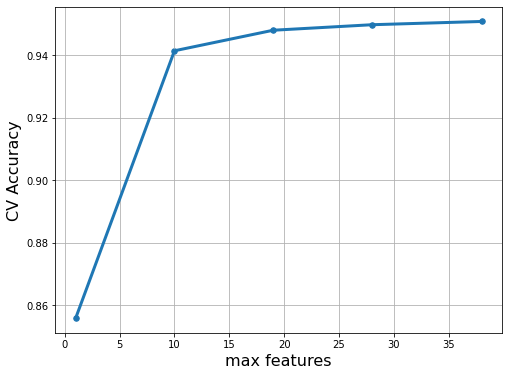

In [110]:
# Plotting the graph to determine the best hyperparameter 'm'
max_features = rf_cv.cv_results_['param_max_features'].data
R2_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV Accuracy', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')

In [111]:
print(rf_cv.best_params_)

{'max_features': 38, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 88}


In [112]:
rf_acc = accuracy_score(y_test, rf_cv.predict(X_test))
rf_acc

0.954969696969697

In [113]:
# Confusion Matrix.
cm = confusion_matrix(y_test, rf_cv.predict(X_test))
print ("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[8260  403]
 [ 340 7497]]


In [114]:
# TPR for Random Forest Model
rf_tpr = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
rf_tpr

0.9566160520607375

In [115]:
# FPR for Random Forest Model
rf_fpr = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
rf_fpr

0.046519681403670785

#### ROC Curve

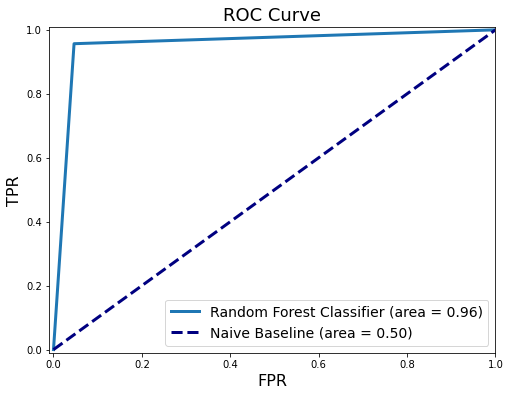

In [116]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, rf_cv.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Random Forest Classifier (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

#### Metrics Table

In [117]:
comparison_data = {'Random Forest Classifier': ['{:.3f}'.format(rf_acc),
                                              '{:.4f}'.format(rf_tpr),
                                              '{:.3f}'.format(rf_fpr)]}


comparison_table = pd.DataFrame(data=comparison_data, index=['Accuracy', 'TPR', 'FPR'])
comparison_table.style.set_properties(**{'font-size': '12pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

,Random Forest Classifier
Accuracy,0.955
TPR,0.9566
FPR,0.047


#### Pokemon Battles: I Choose You!
Let's create some battles and predict the winners!

In [118]:
pokemon_enc[pokemon_enc['Name'] == 'Pikachu']

,#,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,0,1,2,3,4,0,1,2,3,4
30,31,Pikachu,35,55,40,50,50,90,1,0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
pokemon_enc[pokemon_enc['Name'] == 'Onix']

,#,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,0,1,2,3,4,0,1,2,3,4
103,104,Onix,35,45,160,30,45,70,1,0,0.0,-1.0,-1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


In [120]:
test_w = rf_cv.predict([[31, 104, 35, 55, 40, 50, 50, 90, 1, 0, 
                 1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
               35, 45, 160, 30, 45, 70, 1, 0, 
                0.0, -1.0, -1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]])
test_w

array([1])

In [121]:
X_test.iloc[:, 9:28]

,Legendary 1st,0 1st,1 1st,2 1st,3 1st,4 1st,0 1st,1 1st,2 1st,3 1st,4 1st,HP 2nd,Attack 2nd,Defense 2nd,Sp. Atk 2nd,Sp. Def 2nd,Speed 2nd,Generation 2nd,Legendary 2nd
33553,0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80,80,80,80,80,80,4,0
9427,0,0.0,-1.0,-1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,39,52,43,60,50,65,1,0
199,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,2.0,53,51,53,61,56,40,4,0
12447,0,2.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,-1.0,65,60,70,85,75,40,1,0
39489,0,2.0,0.0,0.0,0.0,-1.0,-1.0,-2.0,-2.0,0.0,0.0,90,95,95,70,90,70,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27615,0,2.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,88,107,122,74,75,64,6,0
21964,0,-1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65,40,70,80,140,70,2,0
33321,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0,1,90,45,30,30,40,3,0
40225,0,2.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,43,30,55,40,65,97,3,0


In [122]:
X_test.columns

Index(['First_pokemon', 'Second_pokemon', 'HP 1st', 'Attack 1st',
       'Defense 1st', 'Sp. Atk 1st', 'Sp. Def 1st', 'Speed 1st',
       'Generation 1st', 'Legendary 1st', '0 1st', '1 1st', '2 1st', '3 1st',
       '4 1st', '0 1st', '1 1st', '2 1st', '3 1st', '4 1st', 'HP 2nd',
       'Attack 2nd', 'Defense 2nd', 'Sp. Atk 2nd', 'Sp. Def 2nd', 'Speed 2nd',
       'Generation 2nd', 'Legendary 2nd', '0 2nd', '1 2nd', '2 2nd', '3 2nd',
       '4 2nd', '0 2nd', '1 2nd', '2 2nd', '3 2nd', '4 2nd'],
      dtype='object')

In [123]:
X_test['First_pokemon'][0]

266

#### Pokemon Battles!

In [124]:
def i_choose_you(pokemon_1, pokemon_2):
    feature_array = []
    row1 = (pokemon_enc[pokemon_enc['Name'] == str(pokemon_1)])
    row2 = (pokemon_enc[pokemon_enc['Name'] == str(pokemon_2)])
    
    # Dropping both name columns
    row1 = row1.drop(columns=['Name'], axis = 1)
    row2 = row2.drop(columns=['Name'], axis = 1)
    
    # Adding in the index for both Pokemons first
    feature_array.append(row1.iloc[:, 0].values[0])
    feature_array.append(row2.iloc[:, 0].values[0])
    
    # Dropping both index columns
    row1 = row1.drop(columns=['#'], axis = 1)
    row2 = row2.drop(columns=['#'], axis = 1)
    
    # Appending the features of both Pokemon using two for loops
    for i in range(len(row1.columns)):
        feature_array.append(row1.iloc[:, i].values[0])
        
    for j in range(len(row2.columns)):
        feature_array.append(row2.iloc[:, j].values[0])
    
    winner = rf_cv.predict([feature_array])

    if winner[0] == 1:
        winner_pokemon = pokemon_1
    else:
        winner_pokemon = pokemon_2
    return winner_pokemon

In [125]:
# Pikachu would beat Onix! Still kind of sus on this...
i_choose_you('Pikachu', 'Onix')

'Pikachu'

In [126]:
# Zapdos would beat Pikachu
i_choose_you('Pikachu', 'Zapdos')

'Zapdos'

In [127]:
# Raichu would beat Pikachu.
i_choose_you('Pikachu', 'Raichu')

'Raichu'

In [128]:
i_choose_you('Pikachu', 'Charizard')

'Charizard'

In [129]:
i_choose_you('Pikachu', 'Greninja')

'Greninja'

In [130]:
i_choose_you('Pikachu', 'Kadabra')

'Kadabra'

In [131]:
i_choose_you('Vaporeon', 'Jolteon')

'Jolteon'

In [132]:
i_choose_you('Bulbasaur', 'Venonat')

'Venonat'

In [133]:
i_choose_you('Bulbasaur', 'Vaporeon')

'Vaporeon'

In [134]:
i_choose_you('Snorlax', 'Vaporeon')

'Vaporeon'

In [135]:
i_choose_you('Leafeon', 'Vaporeon')

'Leafeon'

In [136]:
i_choose_you('Leafeon', 'Snorlax')

'Leafeon'

In [137]:
i_choose_you('Bulbasaur', 'Squirtle')

'Bulbasaur'

In [138]:
i_choose_you('Bulbasaur', 'Charmander')

'Charmander'

In [139]:
i_choose_you('Charmander', 'Squirtle')

'Charmander'

### Final Remarks and Conclusion

Just some final remarks because I actually have some for once. :D

I am well aware that thie model is not perfect in anyways. There are some rather questionable results such as Pikachu beating Onix in a battle. Electric versus rock. Rock type Pokemon clearly have the advantage against electric types. This could be attributed to the type of data I collected from Kaggle. Maybe there were an influx of battles where Pikachu just dominated. There are other factors such as the huge pool of movesets that a Pokemon can learn. Some movesets can pretty much determine the outcome of a battle before it even begins. The data I collected only examined stats so in the future I would love to incorporate other features such as the movesets, abilities, and competitiveness of a Pokemon.

Regardless this was still a fun project and I hope to do more like this!